In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("../data/sales_sample.csv")
df.head()


,OrderID,Date,Product,Category,Quantity,UnitPrice,Total,SalesPerson,Country
0,1001,2024-01-01,T-shirt,Apparel,2,12.5,25.0,Asha,India
1,1002,2024-01-02,Jeans,Apparel,1,25.0,25.0,Vikram,USA
2,1003,2024-01-03,Sneakers,Footwear,3,45.0,135.0,Meera,UK
3,1004,2024-01-04,Sandals,Footwear,2,20.0,40.0,Suresh,Germany
4,1005,2024-01-05,Backpack,Accessories,1,35.0,35.0,Priya,Australia


In [5]:
df.info()

# missing counts
print('\nMissing values per column:')
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   OrderID      5 non-null      int64  
 1   Date         5 non-null      object 
 2   Product      5 non-null      object 
 3   Category     5 non-null      object 
 4   Quantity     5 non-null      int64  
 5   UnitPrice    5 non-null      float64
 6   Total        5 non-null      float64
 7   SalesPerson  5 non-null      object 
 8   Country      5 non-null      object 
dtypes: float64(2), int64(2), object(5)
memory usage: 492.0+ bytes

Missing values per column:
OrderID        0
Date           0
Product        0
Category       0
Quantity       0
UnitPrice      0
Total          0
SalesPerson    0
Country        0
dtype: int64


In [6]:
# Convert Date and categories
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
for col in ['Category','SalesPerson']:
    if col in df.columns:
        df[col] = df[col].astype('category')
# YearMonth as string YYYY-MM
df['YearMonth'] = df['Date'].dt.to_period('M').astype(str)
df.info()
df.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderID      5 non-null      int64         
 1   Date         5 non-null      datetime64[ns]
 2   Product      5 non-null      object        
 3   Category     5 non-null      category      
 4   Quantity     5 non-null      int64         
 5   UnitPrice    5 non-null      float64       
 6   Total        5 non-null      float64       
 7   SalesPerson  5 non-null      category      
 8   Country      5 non-null      object        
 9   YearMonth    5 non-null      object        
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 806.0+ bytes


,OrderID,Date,Product,Category,Quantity,UnitPrice,Total,SalesPerson,Country,YearMonth
0,1001,2024-01-01,T-shirt,Apparel,2,12.5,25.0,Asha,India,2024-01
1,1002,2024-01-02,Jeans,Apparel,1,25.0,25.0,Vikram,USA,2024-01
2,1003,2024-01-03,Sneakers,Footwear,3,45.0,135.0,Meera,UK,2024-01


In [7]:
# Drop rows with missing Quantity (if Quantity exists)
if 'Quantity' in df.columns:
    df = df.dropna(subset=['Quantity'])

# Fill UnitPrice with product medians if UnitPrice is missing
if 'UnitPrice' in df.columns and 'Product' in df.columns:
    medians = df.groupby('Product')['UnitPrice'].median()
    df['UnitPrice'] = df.apply(lambda r: medians.get(r['Product'], np.nan) if pd.isna(r['UnitPrice']) else r['UnitPrice'], axis=1)

# Compute Total
if all(c in df.columns for c in ['Quantity','UnitPrice']):
    df['Total'] = (df['Quantity'] * df['UnitPrice']).round(2)
else:
    df['Total'] = np.nan

df[['OrderID','Date','Product','Quantity','UnitPrice','Total']].head(5)


,OrderID,Date,Product,Quantity,UnitPrice,Total
0,1001,2024-01-01,T-shirt,2,12.5,25.0
1,1002,2024-01-02,Jeans,1,25.0,25.0
2,1003,2024-01-03,Sneakers,3,45.0,135.0
3,1004,2024-01-04,Sandals,2,20.0,40.0
4,1005,2024-01-05,Backpack,1,35.0,35.0


In [8]:
# Derived columns
df['OrderMonth'] = df['Date'].dt.to_period('M')
if 'Total' in df.columns and not df['Total'].isna().all():
    thresh = df['Total'].quantile(0.9)
    df['high_value_order'] = df['Total'] > thresh
    print('High value threshold (90th percentile):', thresh)
else:
    df['high_value_order'] = False

df[['OrderID','Date','Total','high_value_order']].head(5)


High value threshold (90th percentile): 97.0


,OrderID,Date,Total,high_value_order
0,1001,2024-01-01,25.0,False
1,1002,2024-01-02,25.0,False
2,1003,2024-01-03,135.0,True
3,1004,2024-01-04,40.0,False
4,1005,2024-01-05,35.0,False


In [9]:
# Aggregations
prod_sales = df.groupby('Product', as_index=False)['Total'].sum().sort_values('Total', ascending=False)
cat_sales = df.groupby('Category', as_index=False)['Total'].sum().sort_values('Total', ascending=False)
sp_sales = df.groupby('SalesPerson', as_index=False)['Total'].sum().sort_values('Total', ascending=False)

print('Top products:')
print(prod_sales.head(6))

print('\nCategory sales:')
print(cat_sales)


Top products:
    Product  Total
3  Sneakers  135.0
2   Sandals   40.0
0  Backpack   35.0
1     Jeans   25.0
4   T-shirt   25.0

Category sales:
      Category  Total
2     Footwear  175.0
1      Apparel   50.0
0  Accessories   35.0


C:\Users\rishi\AppData\Local\Temp\ipykernel_9368\3813736366.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cat_sales = df.groupby('Category', as_index=False)['Total'].sum().sort_values('Total', ascending=False)
C:\Users\rishi\AppData\Local\Temp\ipykernel_9368\3813736366.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sp_sales = df.groupby('SalesPerson', as_index=False)['Total'].sum().sort_values('Total', ascending=False)


In [10]:
# Time series monthly aggregation
if df['Date'].isna().any():
    print('Warning: some Date values are NaT and will be dropped for time series.')

monthly = df.set_index('Date').resample('M')['Total'].sum().rename('MonthlyTotal')
monthly_rolling = monthly.rolling(window=3).mean().rename('3moRolling')
monthly_pct = monthly.pct_change().rename('MonthlyPctChange')

monthly_df = pd.concat([monthly, monthly_rolling, monthly_pct], axis=1)
monthly_df.dropna(how='all').head(12)


C:\Users\rishi\AppData\Local\Temp\ipykernel_9368\980449228.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df.set_index('Date').resample('M')['Total'].sum().rename('MonthlyTotal')


,MonthlyTotal,3moRolling,MonthlyPctChange
Date,,,
2024-01-31,260.0,NaN,NaN


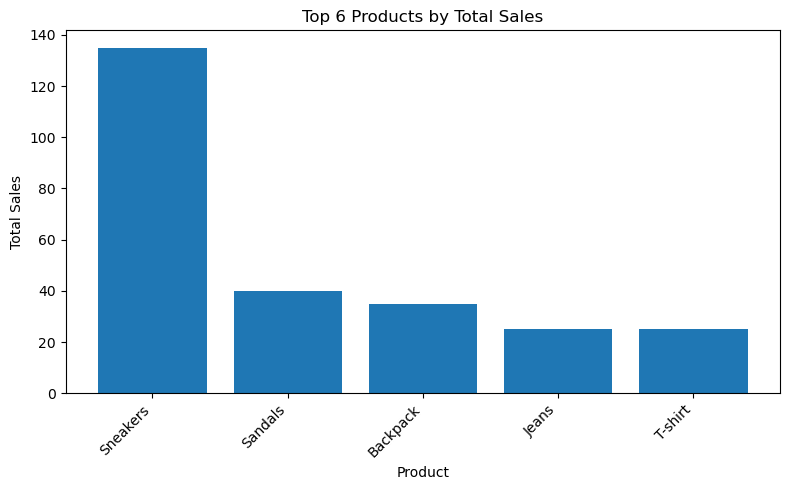

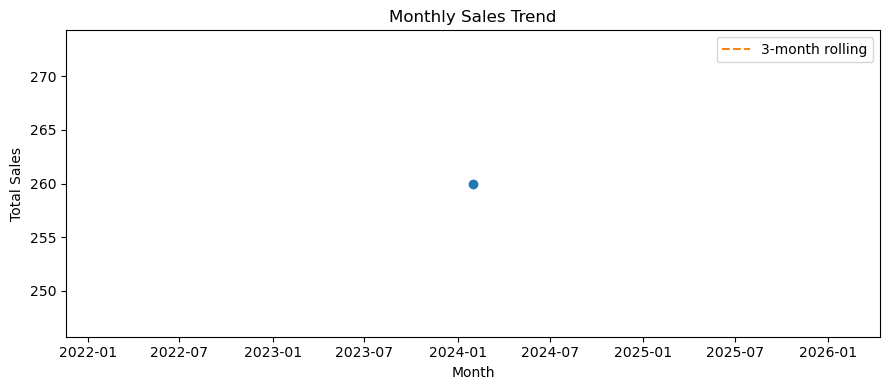

C:\Users\rishi\AppData\Local\Temp\ipykernel_9368\1543024893.py:27: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = last12.pivot_table(index=last12['Date'].dt.to_period('M').astype(str), columns='Category', values='Total', aggfunc='sum', fill_value=0)


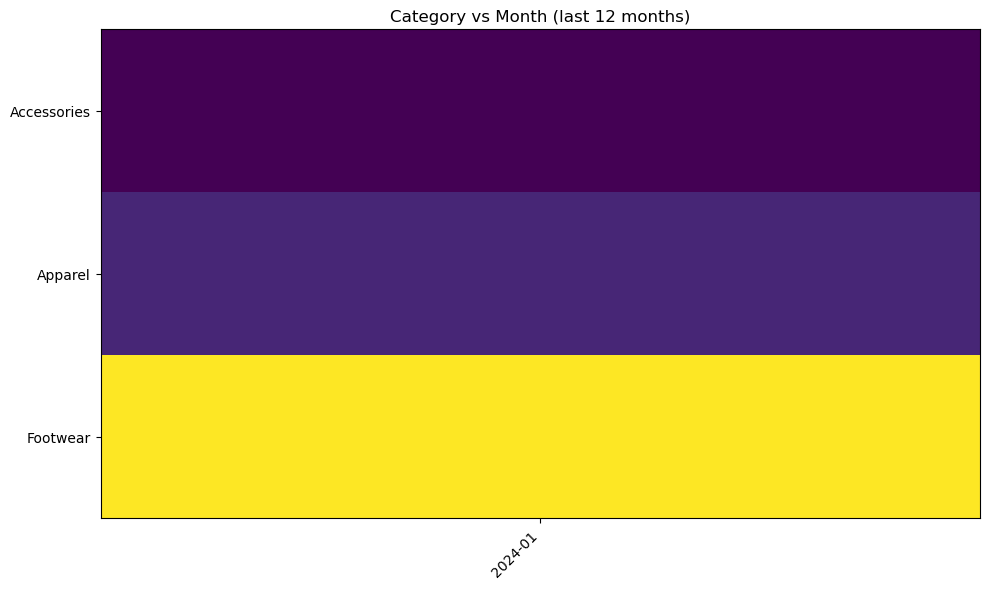

In [19]:
# Top 6 products bar chart
top6 = prod_sales.head(6)
plt.figure(figsize=(8,5))
plt.bar(top6['Product'], top6['Total'])
plt.title('Top 6 Products by Total Sales')
plt.xlabel('Product')
plt.ylabel('Total Sales')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../outputs/top6_products_notebook.png')
plt.show()

# Monthly sales trend
plt.figure(figsize=(9,4))
plt.plot(monthly.index, monthly.values, marker='o')
plt.plot(monthly_rolling.index, monthly_rolling.values, linestyle='--', label='3-month rolling')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/monthly_sales_trend_notebook.png')
plt.show()

# Category vs last-12-months heat-like matrix using pivot (imshow)
last12 = df[df['Date'] >= (df['Date'].max() - pd.DateOffset(months=12))]
pivot = last12.pivot_table(index=last12['Date'].dt.to_period('M').astype(str), columns='Category', values='Total', aggfunc='sum', fill_value=0)
plt.figure(figsize=(10,6))
plt.imshow(pivot.T, aspect='auto')
plt.yticks(range(len(pivot.columns)), pivot.columns)
plt.xticks(range(len(pivot.index)), pivot.index, rotation=45, ha='right')
plt.title('Category vs Month (last 12 months)')
plt.tight_layout()
plt.savefig('../outputs/category_month_heatmap_notebook.png')
plt.show()


## 8. Outliers & sanity checks (IQR method)

In [20]:
# IQR-based outlier detection on Total
Q1 = df['Total'].quantile(0.25)
Q3 = df['Total'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Total'] < Q1 - 1.5*IQR) | (df['Total'] > Q3 + 1.5*IQR)]
print('Outliers count:', len(outliers))
outliers.head(5)


Outliers count: 1


,OrderID,Date,Product,Category,Quantity,UnitPrice,Total,SalesPerson,Country,YearMonth,OrderMonth,high_value_order
2,1003,2024-01-03,Sneakers,Footwear,3,45.0,135.0,Meera,UK,2024-01,2024-01,True
